# **BUCK CONVERTER SIMULATION**
By Dhonan Nabil Hibatullah, Alfarobi V12

The following circuit diagram shows a simple buck converter circuit.

![Buck Converter](assets/buck_converter.jpg "Buck Converter")
**<center>Buck Converter</center>**

The P-channel MOSFET switching is done with a PWM signal. There are two states we need to consider in analyzing the circuit.

## **A. ON State (S Closed)**
In this state, the voltage source, the inductor, and the capacitor are series-connected, forming a loop while connected to a load. Thus, with KVL, KCL, and LC characteristics, we obtain:

$$V_s = v_L(t) + v_C(t) \quad (A.1)$$

$$i_L(t) = i_C(t) + i_R(t) \quad (A.2)$$

$$v_C(t) = v_R(t) \quad (A.3)$$

$$i_C(t) = C\frac{dv_C(t)}{dt} \quad (A.4)$$

$$v_L(t) = L\frac{di_L(t)}{dt} \quad (A.5)$$

Substituting $(A.2)$ to $(A.5)$:

$$v_L(t) = L\frac{di_C(t)}{dt} + L\frac{di_R(t)}{dt} \quad (A.6)$$

Proceed with $(A.4)$:

$$v_L(t) = LC\frac{d^2v_C(t)}{dt^2} + L\frac{di_R(t)}{dt} \quad (A.7)$$

By Ohm's Law and $(A.3)$, notice that $i_R(t) = v_R(t)/R = v_C(t)/R$. Therefore, $(A.7)$ becomes:

$$v_L(t) = LC\frac{d^2v_C(t)}{dt^2} + \frac{L}{R}\frac{dv_C(t)}{dt} \quad (A.8)$$

Finally, combine $(A.1)$ and $(A.8)$:

$$V_s = LC\frac{d^2v_C(t)}{dt^2} + \frac{L}{R}\frac{dv_C(t)}{dt} + v_C(t)$$

$$\Longrightarrow \quad \frac{1}{LC}V_s = \ddot{v}_C(t) + \frac{1}{RC}\dot{v}_C(t) + \frac{1}{LC}v_C(t) \quad (A.9)$$

## **B. OFF State (S Open)**
Instead of $V_s$, we use a non-linear model of diode's forward bias voltage $v_D$. Thus, the resulting KVL is:

$$v_D(i_L(t)) = v_L(t) + v_C(t) \quad (B.1)$$

The rest is pretty much the same as the ON state, therefore:

$$v_D(i_L(t)) = LC\frac{d^2v_C(t)}{dt^2} + \frac{L}{R}\frac{dv_C(t)}{dt} + v_C(t)$$

$$\Longrightarrow \quad \frac{1}{LC}v_D(i_L(t)) = \ddot{v}_C(t) + \frac{1}{RC}\dot{v}_C(t) + \frac{1}{LC}v_C(t) \quad (B.2)$$

## **C. State-Space Model**
From $(A.9)$, let: 

$$x_1 = v_C$$
$$x_2 = \dot{v}_C$$
$$\dot{x}_1 = x_2$$
$$\dot{x}_2 = - \frac{1}{LC}x_1 - \frac{1}{RC}x_2 + \frac{1}{LC}V_s$$

Hence, the state-space equation:

$$\begin{bmatrix}
\dot{x}_1 \\ 
\dot{x}_2
\end{bmatrix} =
\begin{bmatrix}
0 & 1 \\
-\frac{1}{LC} & -\frac{1}{RC}
\end{bmatrix}\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix} + 
\begin{bmatrix}
0 \\
\frac{1}{LC}
\end{bmatrix}V_s \quad (C.1)$$

Let us do the same with $(B.2)$:

$$x_1 = v_C$$
$$x_2 = \dot{v}_C$$
$$\dot{x}_1 = x_2$$
$$\dot{x}_2 =- \frac{1}{LC}x_1 - \frac{1}{RC}x_2 + \frac{1}{LC}v_D$$

$$\begin{bmatrix}
\dot{x}_1 \\ 
\dot{x}_2
\end{bmatrix} =
\begin{bmatrix}
0 & 1 \\
-\frac{1}{LC} & -\frac{1}{RC}
\end{bmatrix}\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix} + 
\begin{bmatrix}
0 \\
\frac{1}{LC}
\end{bmatrix}v_D \quad (C.2)$$

Let us combine $(C.1)$ and $(C.2)$:

$$\begin{bmatrix}
\dot{x}_1 \\ 
\dot{x}_2
\end{bmatrix} =
\begin{bmatrix}
0 & 1 \\
-\frac{1}{LC} & -\frac{1}{RC}
\end{bmatrix}\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix} + 
\begin{bmatrix}
0 \\
\frac{1}{LC}
\end{bmatrix}\left[u(\sigma) V_s + u(-\sigma) v_D \right] \quad (C.3)$$

where 
 - $\sigma = 1$ when ON, $-1$ when OFF
 - $u(k) = 1$ when $k > 0$, $0$ when $k \leq 0$ 

## **D. Simulation**
Let us demonstrate the equation $(C.3)$ with $V_s = 16.8\text{V}$, $V_D = 0\text{V}$, $T = 12.5\mu\text{s}$, $T_{on} = 0.83T$, $L = 330\mu\text{H}$, $C = 4.7\text{mF}$, and $R = 0.5\Omega$.

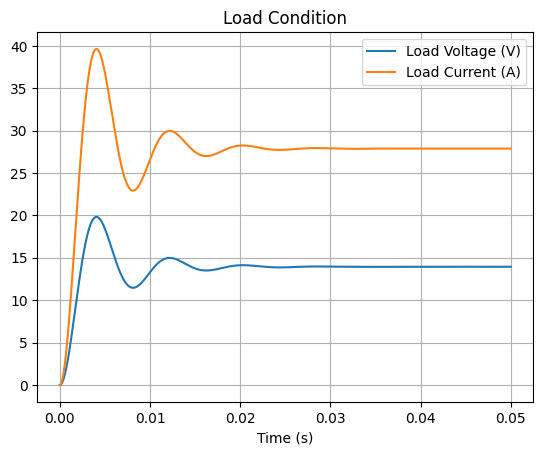

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# SIMULATION VARIABLES
t_sim       = 0.0
t_per       = 0.0
t_step      = 1e-8
sim_step    = 5000000


# MODEL VARIABLES
V_s     = 16.8
V_D     = 0.0
T_sig   = 12.5e-6
T_on    = T_sig*0.83
L       = 330e-6
C       = 4.7e-3
R       = 0.5
ov_LC   = 1./(L*C)
ov_RC   = 1./(R*C)


# STATE SPACE EQUATION
def ss_equation(state:np.ndarray) -> np.ndarray:
    global t_per

    # reset time per period
    if t_per >= T_sig:
        t_per -= T_sig

    # determine sigma, u_s, and u_D
    sigma   = 1.0 if t_per < T_on else -1.0
    u_s     = 1.0 if sigma > 0.0 else 0.0
    u_D     = 1.0 if -sigma > 0.0 else 0.0

    # return the resulting state
    A = np.array([
        [0.0, 1.0],
        [-ov_LC, -ov_RC]
    ])

    B = np.array([
        [0.0],
        [ov_LC]
    ])

    u = np.array([
        [u_s*V_s + u_D*V_D]
    ])

    return state + (A@state + B@u)*t_step


# START SIMULATION
state = np.array([
    [0.0],
    [0.0]
])

vol_arr     = [state[0].item()]
amp_arr     = [state[0].item()/R]
time_arr    = [t_sim]

for i in range(sim_step):
    t_sim += t_step
    t_per += t_step

    state = ss_equation(state)

    vol_arr.append(state[0].item())
    amp_arr.append(state[0].item()/R)
    time_arr.append(t_sim)


# PLOT THE RESULT
plt.title('Load Condition')
plt.xlabel('Time (s)')
plt.plot(time_arr, vol_arr, label='Load Voltage (V)')
plt.plot(time_arr, amp_arr, label='Load Current (A)')
plt.grid()
plt.legend()
plt.show()